**How do student’s travel,study and free time, number of school absences and overall health affect the final grade?**

Portugal’s education is at the tail end of Europe’s educational level due to student failure and dropout rates (Cortez and Silvia, 2008). 
In 2006 Portugal's early school dropout rate was 40% for 18-24 year olds while the EU average was 15% (Cortez and Silvia, 2008). 
Particularly in Math core classes, which are built upon in later courses, failure rates were high (Cortez and Silvia, 2008). 
Using Business Intelligence (BI) and Data Mining (DM) methods to analyze trends could inform decision making around academic infrastructural support and corrective measures (Cortez and Silvia, 2008).

The data set that is going to be used is called Student Performance Data Set and  is provided by the University of Minho. It records 33 attributes (binary, nominal and numeric) such as gender, age, parents’ educational levels and occupations, the time students spend traveling to school, and personal time, among other factors that may affect students’ grades (Cortez and Silvia, 2008). 

Our data analysis will use travel,study and free time, number of school absences and overall health of student’s to determine their final Math grade(G3). Although the earlier grades G1 and G2 are helpful in predicting the final grade G3 our classification model will be explored without taking into consideration those factors. 


In [15]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.plot.width = 10, repr.plot.height = 10) 

**Methods**

Firstly, data frame is loaded from the original web source:

In [16]:
# Read the zip file from url and unzip so it can be loaded into a dataframe
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip"
zip_file <- tempfile(fileext = ".zip")
download.file(url, zip_file, mode = "wb")
student_data <- read_delim(unz(description = zip_file, filename = "student-mat.csv"), delim = ";")

Parsed with column specification:
cols(
  .default = col_character(),
  age = col_double(),
  Medu = col_double(),
  Fedu = col_double(),
  traveltime = col_double(),
  studytime = col_double(),
  failures = col_double(),
  famrel = col_double(),
  freetime = col_double(),
  goout = col_double(),
  Dalc = col_double(),
  Walc = col_double(),
  health = col_double(),
  absences = col_double(),
  G1 = col_double(),
  G2 = col_double(),
  G3 = col_double()
)

See spec(...) for full column specifications.



Due to the fact that the final grades in the data set are distributed from 0 to 20, they are grouped according to Portuguese universities’ 5-level grade classification for easier classification. Grades 0-9 are a ‘fail’, 10-11 are ‘sufficient’, 12-13 are ‘satisfactory’, 14-15 are ‘good’, and 16-20 are ‘excellent’. 

In [17]:
# Grouped the Final Grade into intervals for easier labelling down the line
# Grades 0-5 is 1, 6-10 is 2, 11-15 is 3 and 16-20 is 4

student_data_group <- student_data %>%
    mutate(label = cut(G3, c(0, 9, 11, 13, 15, 20), 
                       #labels = c("fail", "sufficient", "satisfactory", "good", "excellent"), 
                       labels = c(1, 2, 3, 4, 5),
                       left = FALSE)) %>%
    group_by(label = as.factor(label)) %>%
    filter(!is.na(label))

head(student_data_group)

school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,⋯,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,label
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
GP,F,18,U,GT3,A,4,4,at_home,teacher,⋯,3,4,1,1,3,6,5,6,6,1
GP,F,17,U,GT3,T,1,1,at_home,other,⋯,3,3,1,1,3,4,5,5,6,1
GP,F,15,U,LE3,T,1,1,at_home,other,⋯,3,2,2,3,3,10,7,8,10,2
GP,F,15,U,GT3,T,4,2,health,services,⋯,2,2,1,1,5,2,15,14,15,4
GP,F,16,U,GT3,T,3,3,other,other,⋯,3,2,1,2,5,4,6,10,10,2
GP,M,16,U,LE3,T,4,3,services,other,⋯,4,2,1,2,5,10,15,15,15,4


Columns with binary data are removed as we were informed that initially they would not make suitable factors in KNN classification.


In [18]:
student_data_group_no_bin <- student_data_group %>%
    select(Medu, Fedu, traveltime, studytime, failures, famrel, freetime, goout, Dalc, Walc, health, absences, G1, G2, G3, label)

head(student_data_group_no_bin)

Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,label
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
4,4,2,2,0,4,3,4,1,1,3,6,5,6,6,1
1,1,1,2,0,5,3,3,1,1,3,4,5,5,6,1
1,1,1,2,3,4,3,2,2,3,3,10,7,8,10,2
4,2,1,3,0,3,2,2,1,1,5,2,15,14,15,4
3,3,1,2,0,4,3,2,1,2,5,4,6,10,10,2
4,3,1,2,0,5,4,2,1,2,5,10,15,15,15,4


Due to the dataset being small (n = 268), we will allocate a large portion for our training set. Since we are limited by the small size of our data set, we must allocate more into the training set so that we can produce a better predictive model. We also want to balance the amount in our testing set otherwise it may not be representative of the overall set. As such, we have selected to use 75% for our training set and 25% for our testing set.

In [19]:
# Split the data into training and testing set
#student_data_split <- initial_split(student_data_cleaned_binary, prop = 0.75, strata = label)
set.seed(2021)
student_data_split <- initial_split(student_data_group_no_bin, prop = 0.75, strata = label)
student_train <- training(student_data_split)
student_test <- testing(student_data_split)


Preliminary data analysis to look at where the largest counts or average lies for certain factors.

In [34]:
# Exploratory Data Analysis
# Distribution of mother's education level
student_train_meduc <- group_by(student_train, Medu) %>%
    summarize(n = n()) 

# Distribution of father's education level
student_train_feduc <- group_by(student_train, Fedu) %>%
    summarize(n = n())

# Counts number of student failures
student_train_failure <- group_by(student_train, failures) %>%
    summarize(n=n())

# Counts number of student absences
student_train_absences <- group_by(student_train, absences) %>%
    summarize(n=n())

# Computes mean of student absences, family relationship quality, overall health status, travel time
student_train_mean <- group_by(student_train) %>%
    summarize(absences = mean(absences), 
              famrel = mean(famrel),
             health = mean(health),
             traveltime = mean(traveltime),
             studytime = mean(studytime),
             freetime = mean(freetime),
             goout = mean(goout),
             Dalc = mean(Dalc),
             Walc = mean(Walc))


# Student final grade distribution
student_train_G3 <- group_by(student_train, G3) %>%
    summarize(n = n())

student_train_meduc
student_train_feduc
student_train_failure
head(student_train_absences)
student_train_mean

head(student_train_G3)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



Medu,n
<dbl>,<int>
0,3
1,35
2,65
3,66
4,100


Fedu,n
<dbl>,<int>
0,1
1,55
2,70
3,78
4,65


failures,n
<dbl>,<int>
0,222
1,34
2,8
3,5


absences,n
<dbl>,<int>
0,61
1,3
2,49
3,6
4,41
5,4


absences,famrel,health,traveltime,studytime,freetime,goout,Dalc,Walc
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6.137546,3.94052,3.587361,1.442379,2.074349,3.200743,3.05948,1.460967,2.315985


G3,n
<dbl>,<int>
4,1
5,4
6,12
7,7
8,25
9,20


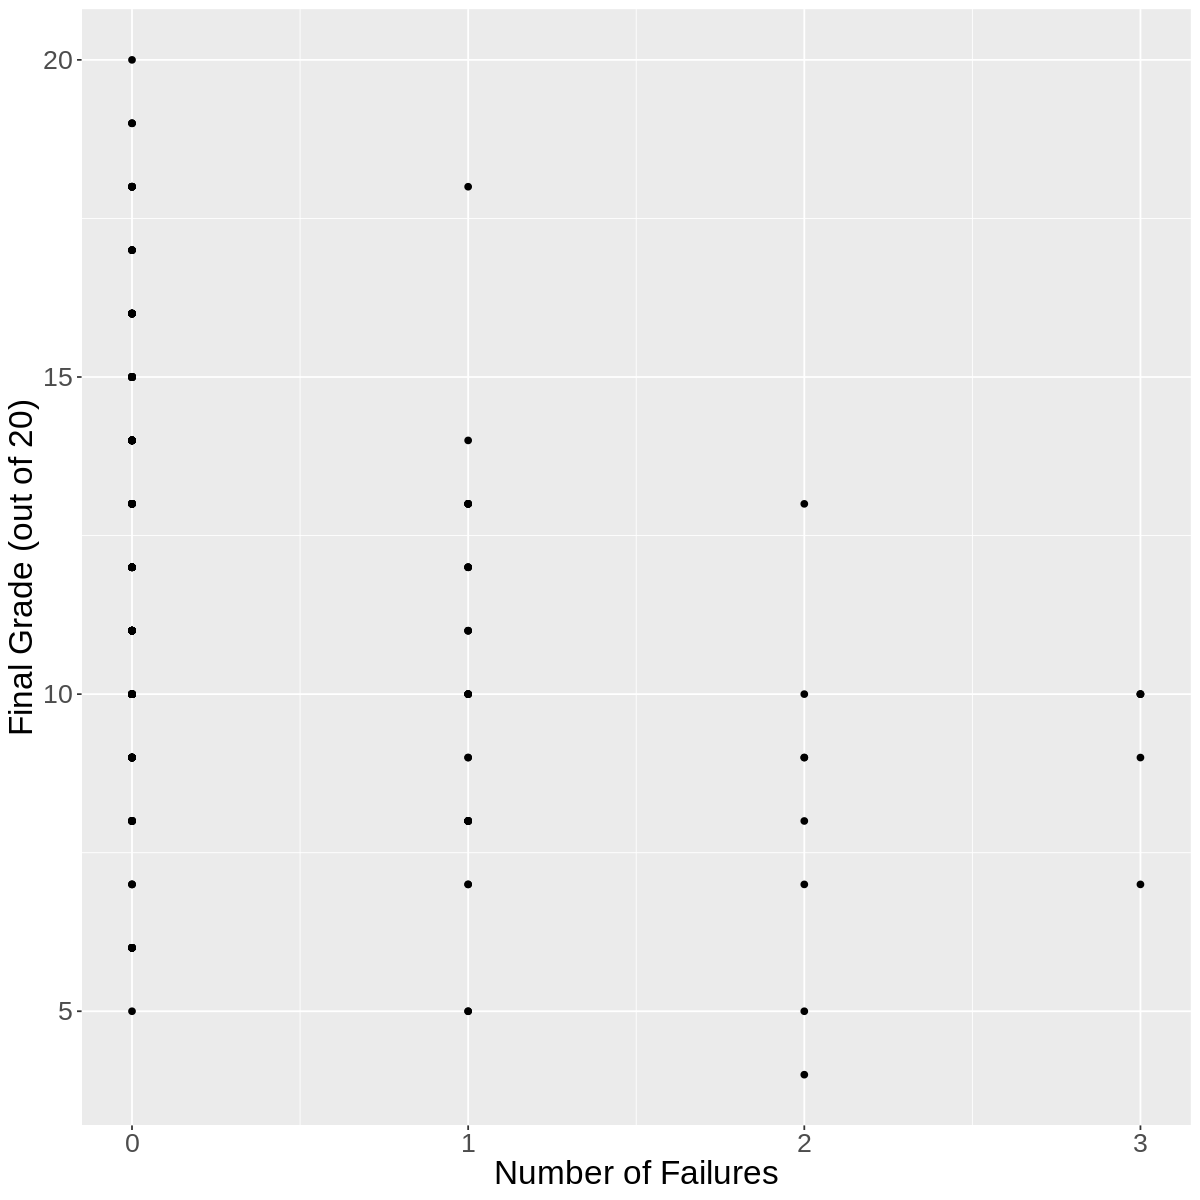

In [21]:
# Exploratory plot of Final Grade vs Number of Failures
student_plot <- ggplot(student_train, aes(x = failures, y = G3)) +
    geom_point() +
    labs(x = "Number of Failures" , y = "Final Grade (out of 20)") +
    theme(text = element_text(size = 20))
student_plot

From this graph, we can see a general trend that those with more class failures tend to have a lower final grade. It is also important to see that even those that with low to no failures have a wide range of final grades.

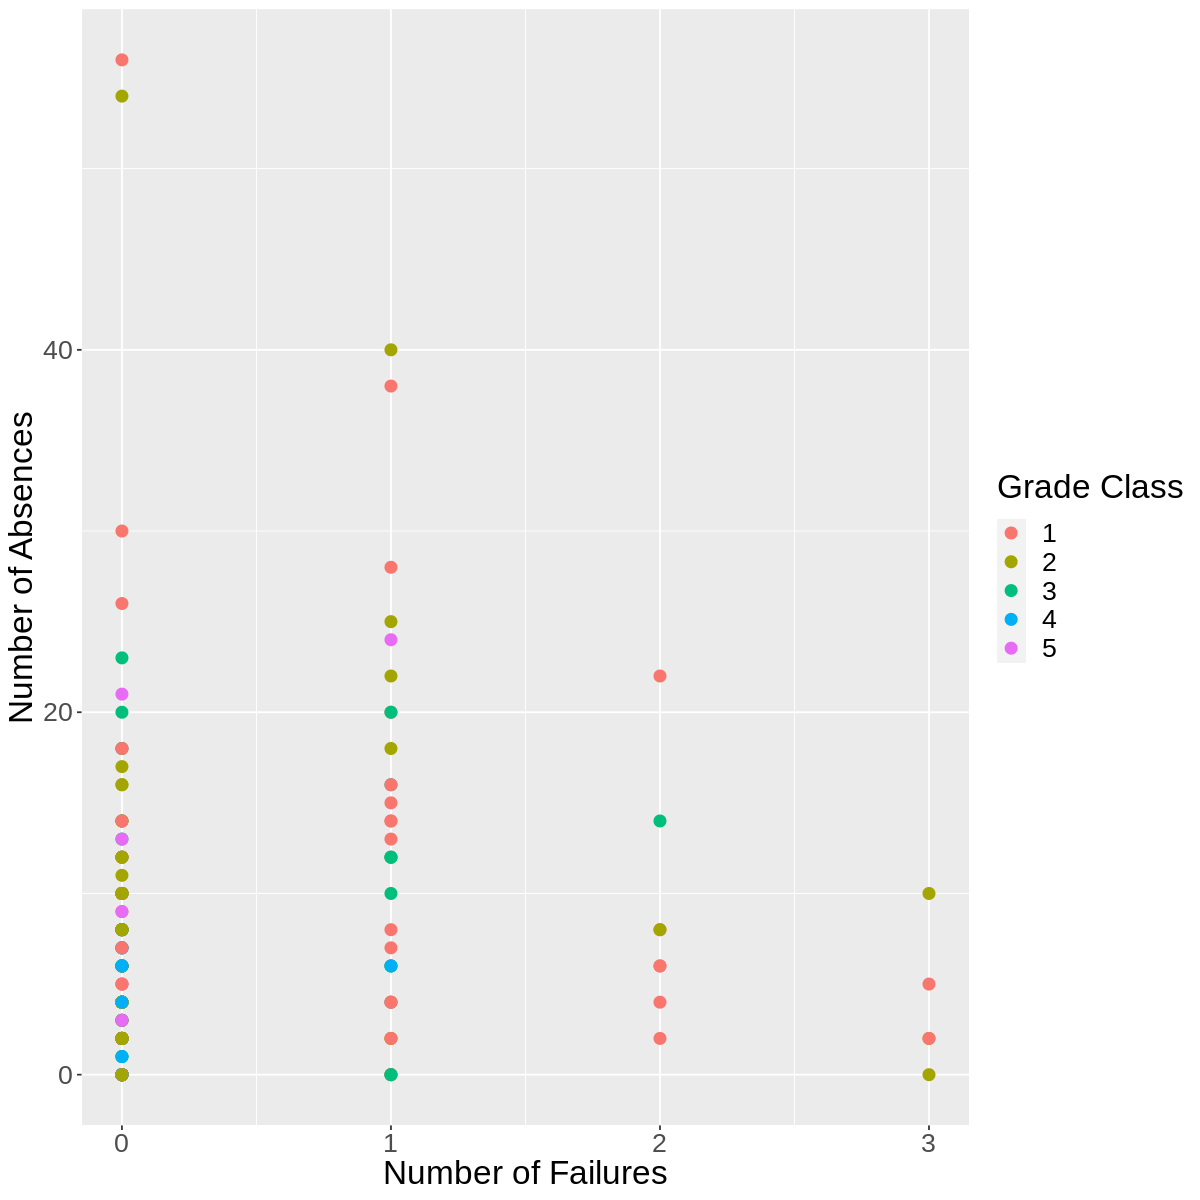

In [22]:
# Exporatory plot of Number of Absences vs Number of Failure with Grades as class labels
student_plot2 <- ggplot(student_train, aes(x = failures, y = absences, fill = label)) +
    geom_point(aes(color = label), size = 3) +
    labs(x = "Number of Failures" , y = "Number of Absences", fill = "Grade Class", color = "Grade Class") +
    theme(text = element_text(size = 20))
student_plot2

On this graph, the details are a bit more clear. One might expect a different distribution of data points on this graph, where the data points are more towards the top right of the graph meaning that those with a high number of class absences would also fail more classes. An important note here is that students who score a high grade in class both have low number of failures (0-1) and low number of absences (<20).

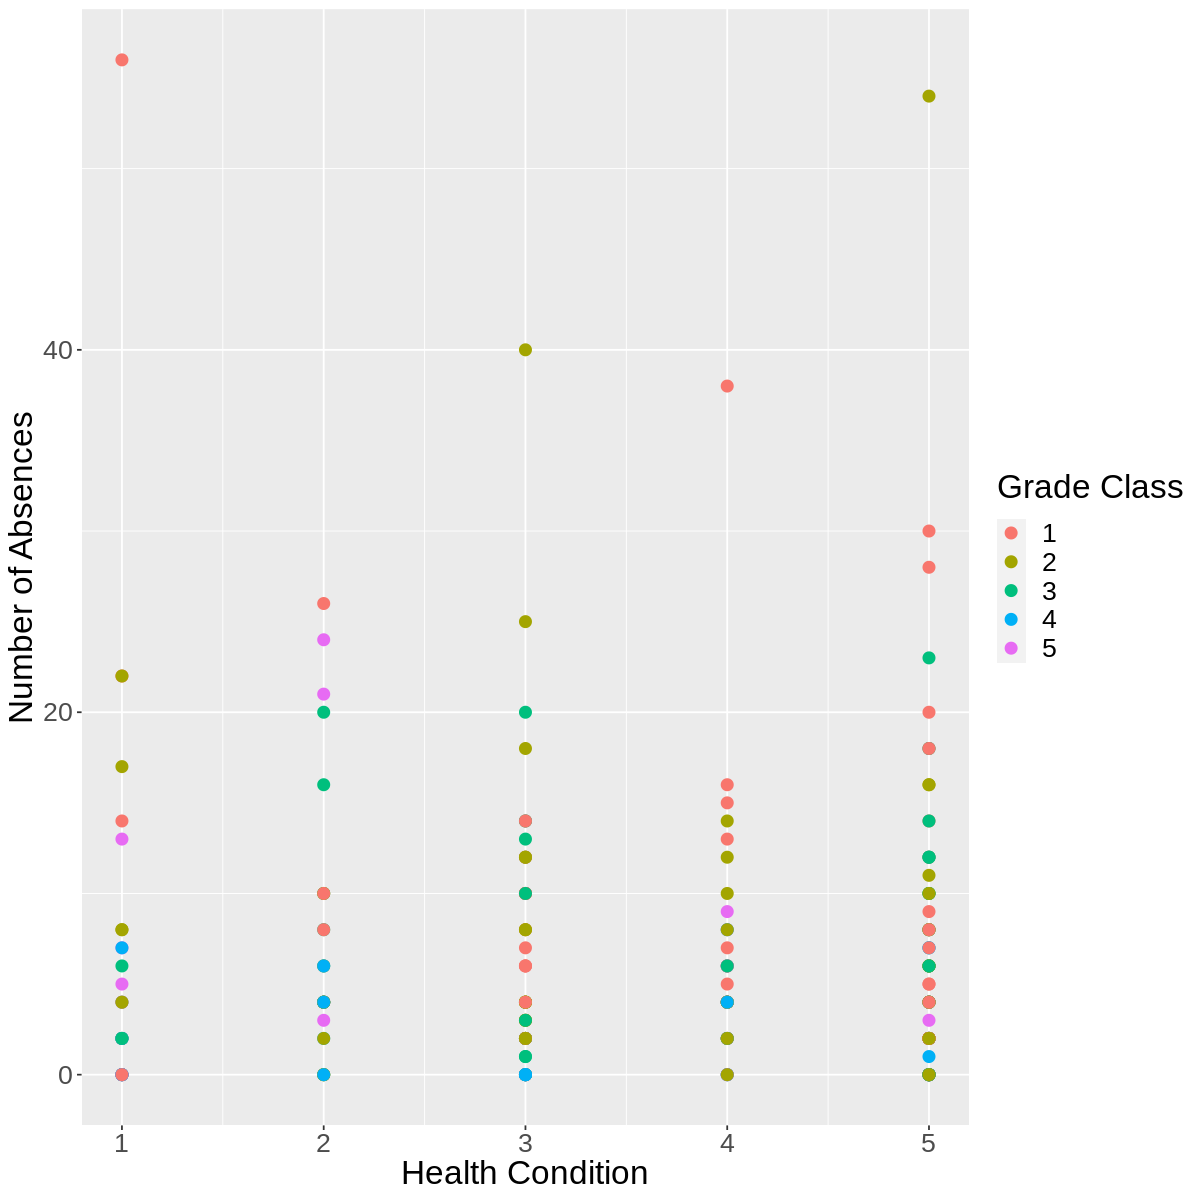

In [23]:
# Exporatory plot of Number of Absences vs Health with Grades as class labels
student_plot2 <- ggplot(student_train, aes(x = health, y = absences, fill = label)) +
    geom_point(aes(color = label), size = 3) +
    labs(x = "Health Condition" , y = "Number of Absences", fill = "Grade Class", color = "Grade Class") +
    theme(text = element_text(size = 20))
student_plot2

From this graph, we can see that students with high grades will have low number of absences regardless of their health condition, while having a low number of absences. At the same time, students, regardless of their health condition, will have a low grade if they have a higher number of absences. This may suggest that health does not play a large role in predicting their grade.

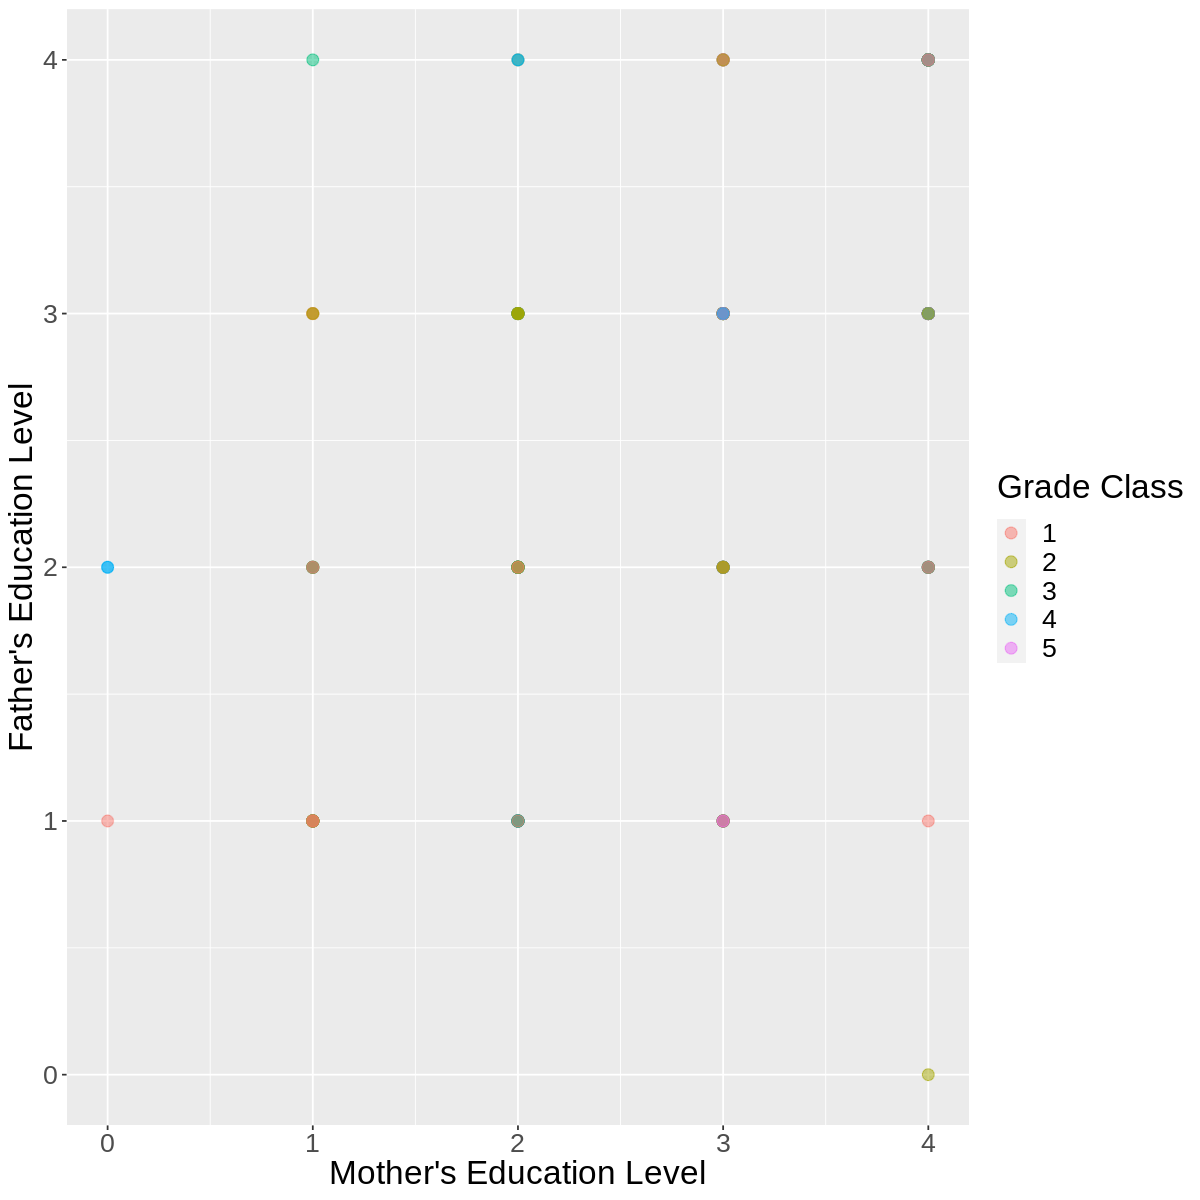

In [37]:
# REMOVE
# Exporatory plot of Mother's vs Father's Education Level with Grades as class labels
student_plot3 <- ggplot(student_train, aes(x = Medu, y = Fedu, fill = label)) +
    geom_point(aes(color = label), size = 3, alpha = 0.5) +
    labs(x = "Mother's Education Level" , y = "Father's Education Level", fill = "Grade Class", color = "Grade Class") +
    theme(text = element_text(size = 20))
student_plot3

We initially thought that Mother and Father's education level would play a role in their final grade since it maybe expected that children of highly educated parents also strive for higher education and thus achieve higher grades. From this plot, it appears that the mother's education level plays a larger role in determine the grades.

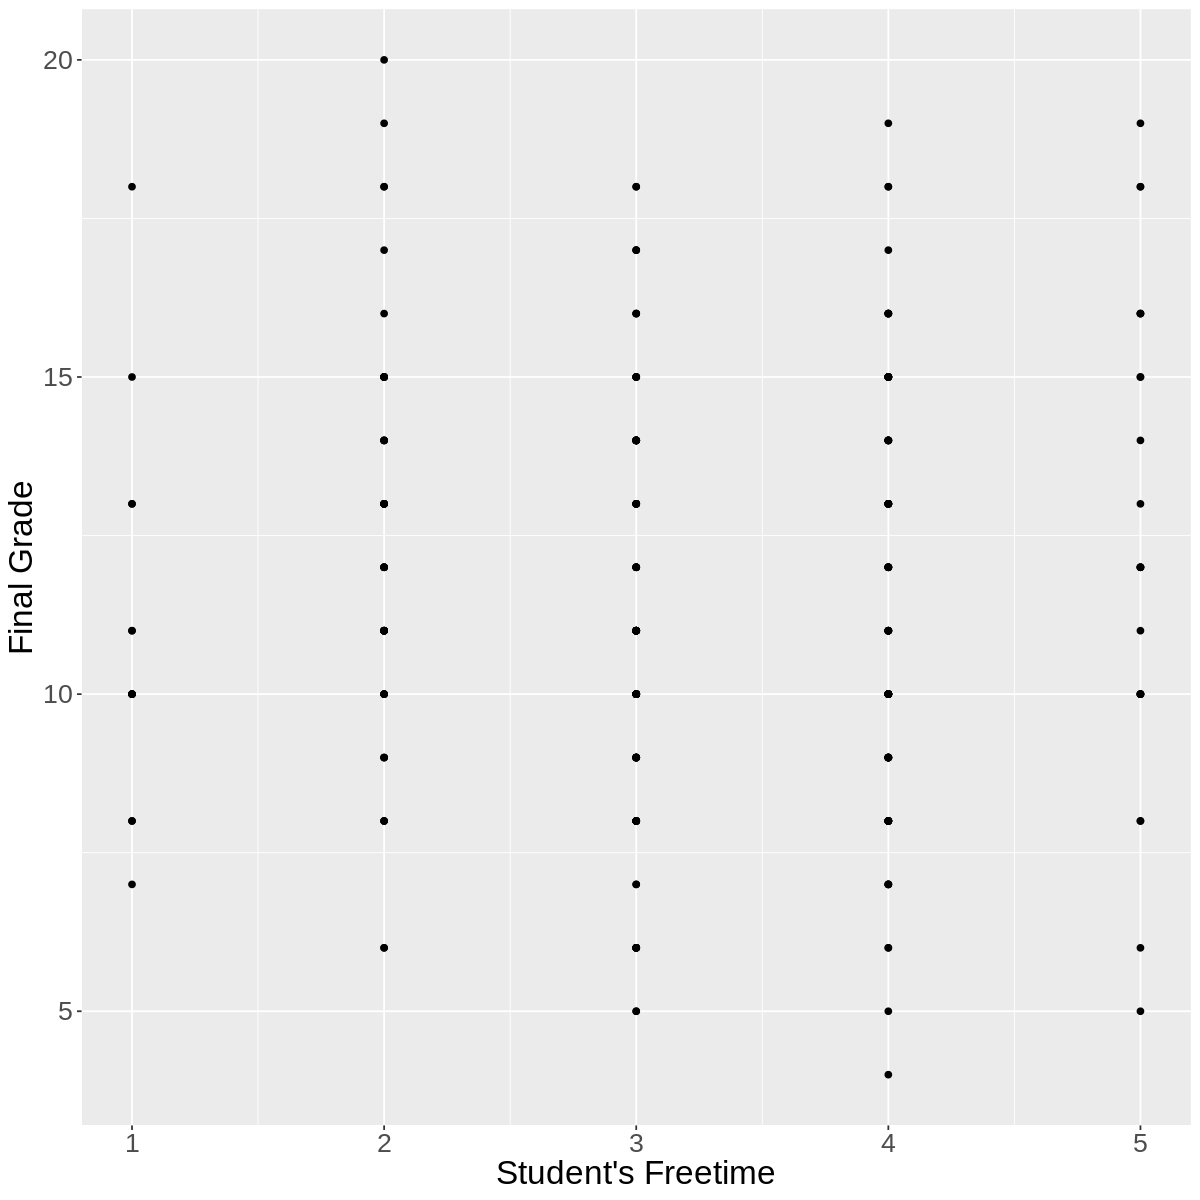

In [41]:
student_plot5 <- ggplot(student_train, aes(x = freetime, y = G3)) + #, fill = label)) +
    geom_point() + #aes(color = label), size = 3, alpha = 0.5) +
    labs(x = "Student's Freetime" , y = "Final Grade") + #, fill = "Grade Class", color = "Grade Class") +
    theme(text = element_text(size = 20))
student_plot5

This graph suggests that a student's freetime has little to no effect on their final grade.

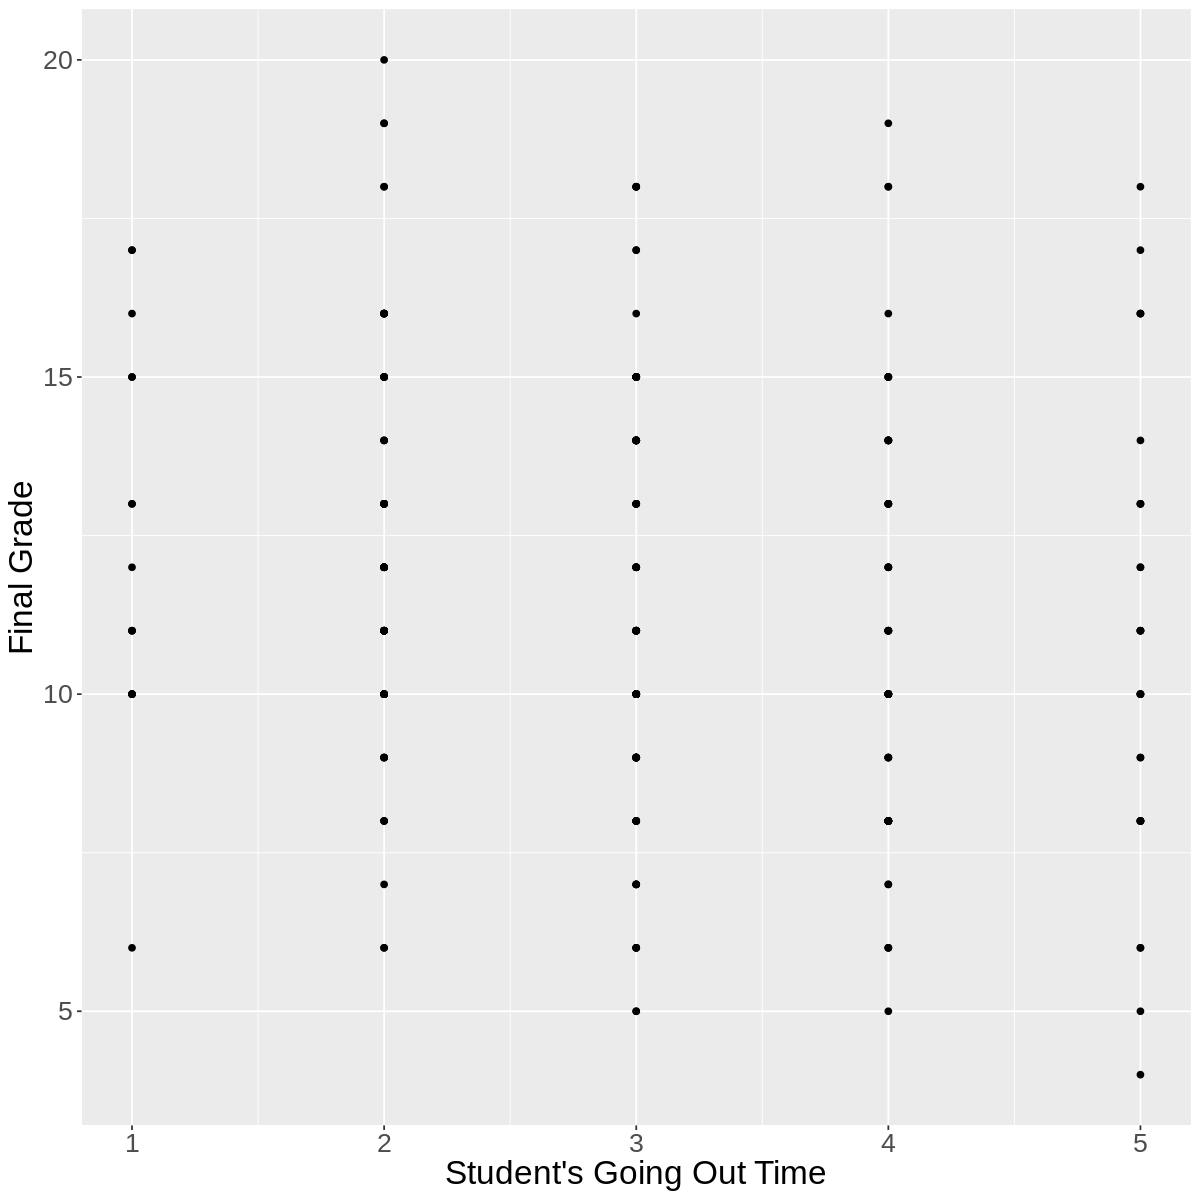

In [42]:
student_plot6 <- ggplot(student_train, aes(x = goout, y = G3)) + 
    geom_point() + 
    labs(x = "Student's Going Out Time" , y = "Final Grade") + 
    theme(text = element_text(size = 20))
student_plot6

This graph suggests that a student's time spent going out has little effect on Final Grade.

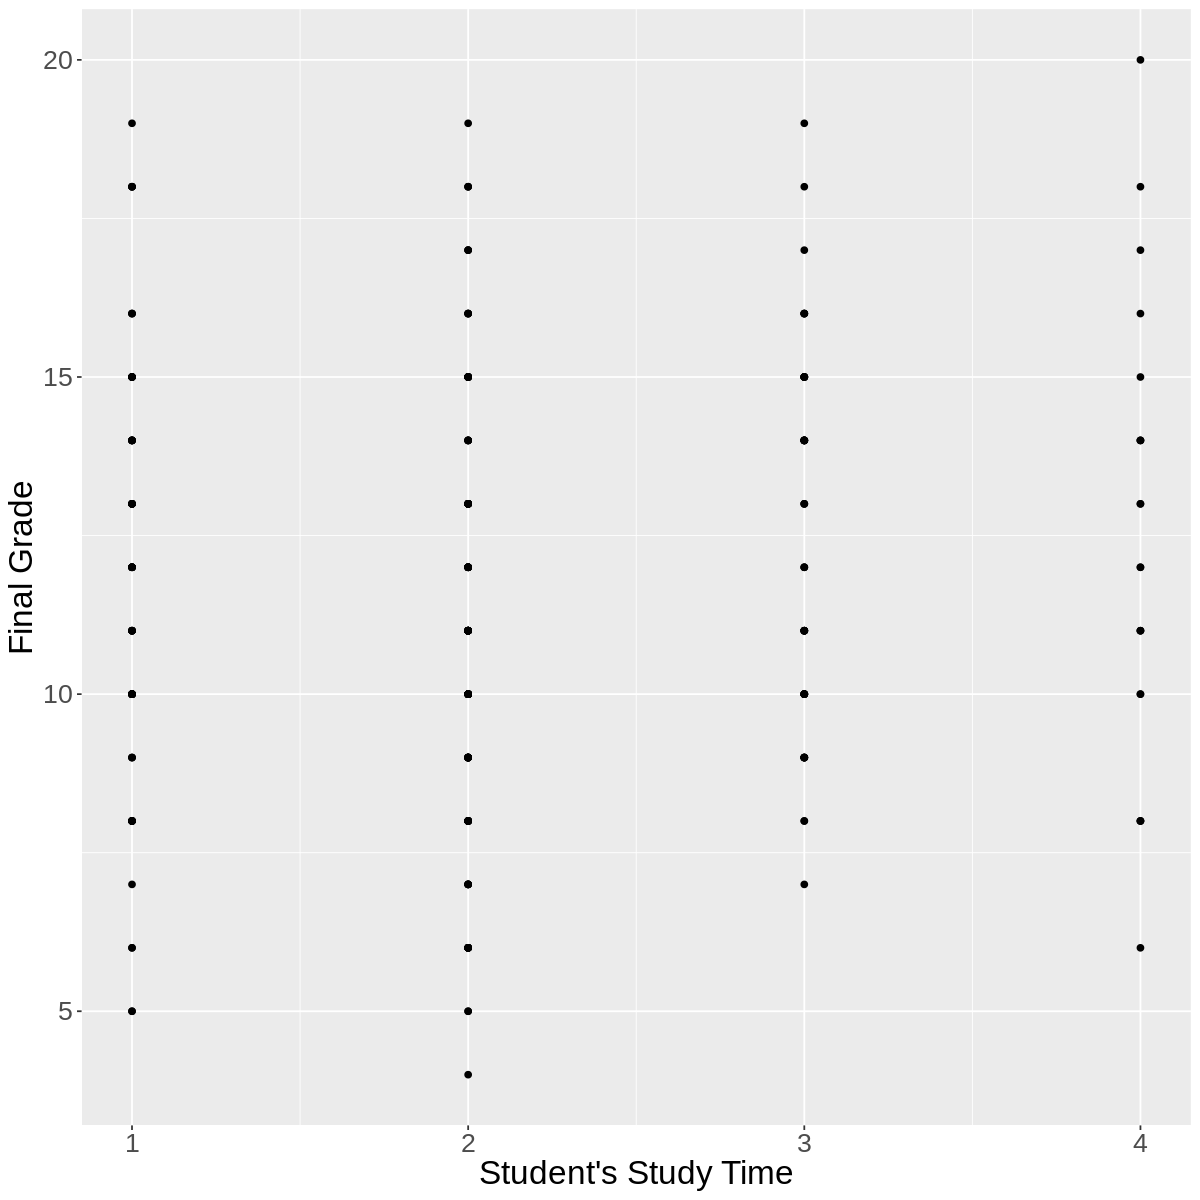

In [43]:
student_plot7 <- ggplot(student_train, aes(x = studytime, y = G3)) + 
    geom_point() + 
    labs(x = "Student's Study Time" , y = "Final Grade") + 
    theme(text = element_text(size = 20))
student_plot7

This is a surprising plot since it suggests that studying more will not result in a higher final grade. But zooming out we can see that students that do study more will not achieve extremely low scores like their counterparts who studied less.

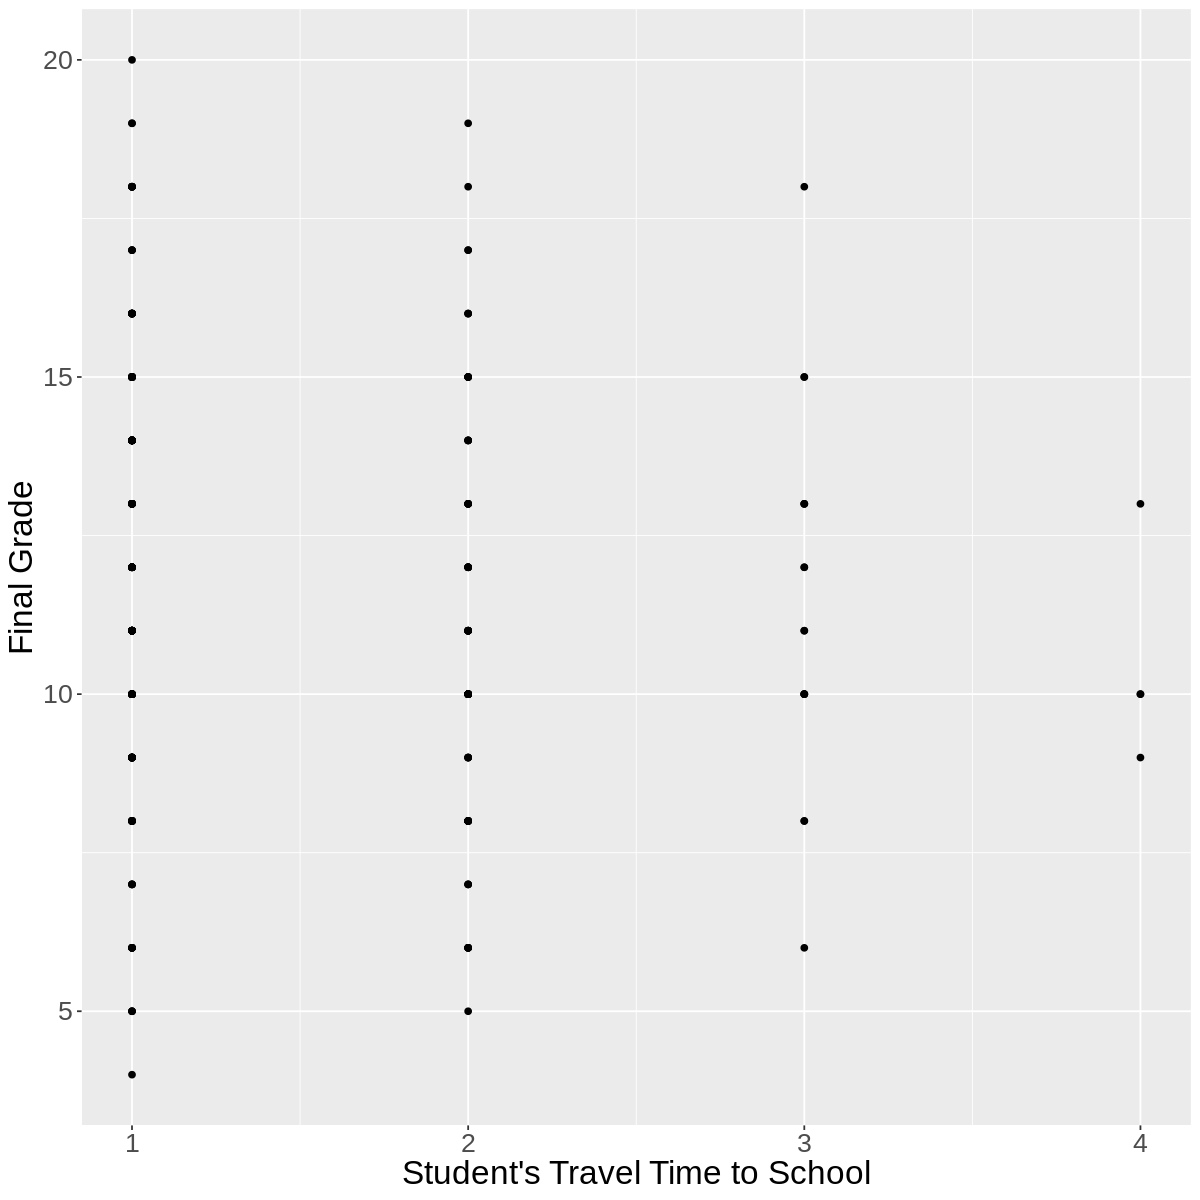

In [44]:
student_plot8 <- ggplot(student_train, aes(x = traveltime, y = G3)) + 
    geom_point() + 
    labs(x = "Student's Travel Time to School" , y = "Final Grade") + 
    theme(text = element_text(size = 20))
student_plot8

Here we can see as travel time increases, the grades converge resulting in a lower highest grade and a higher lowest grade compares to students who spent less time travelling.

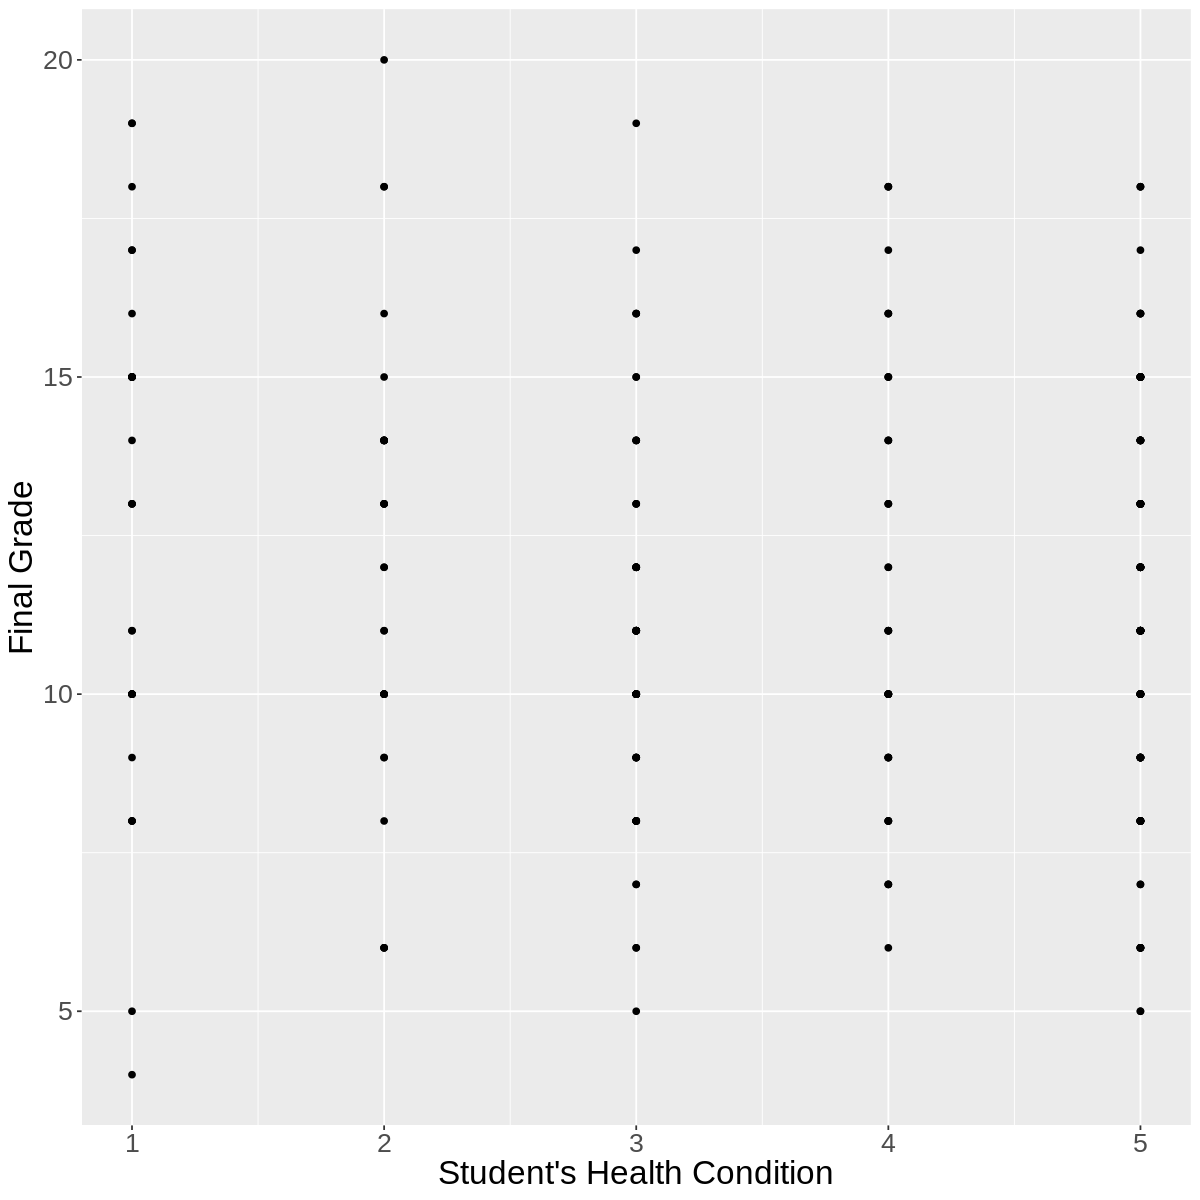

In [45]:
student_plot9 <- ggplot(student_train, aes(x = health, y = G3)) + 
    geom_point() + 
    labs(x = "Student's Health Condition" , y = "Final Grade") + 
    theme(text = element_text(size = 20))
student_plot9

This graph solidifies the suggestion that the student's health condition plays little into determining a student's grade.

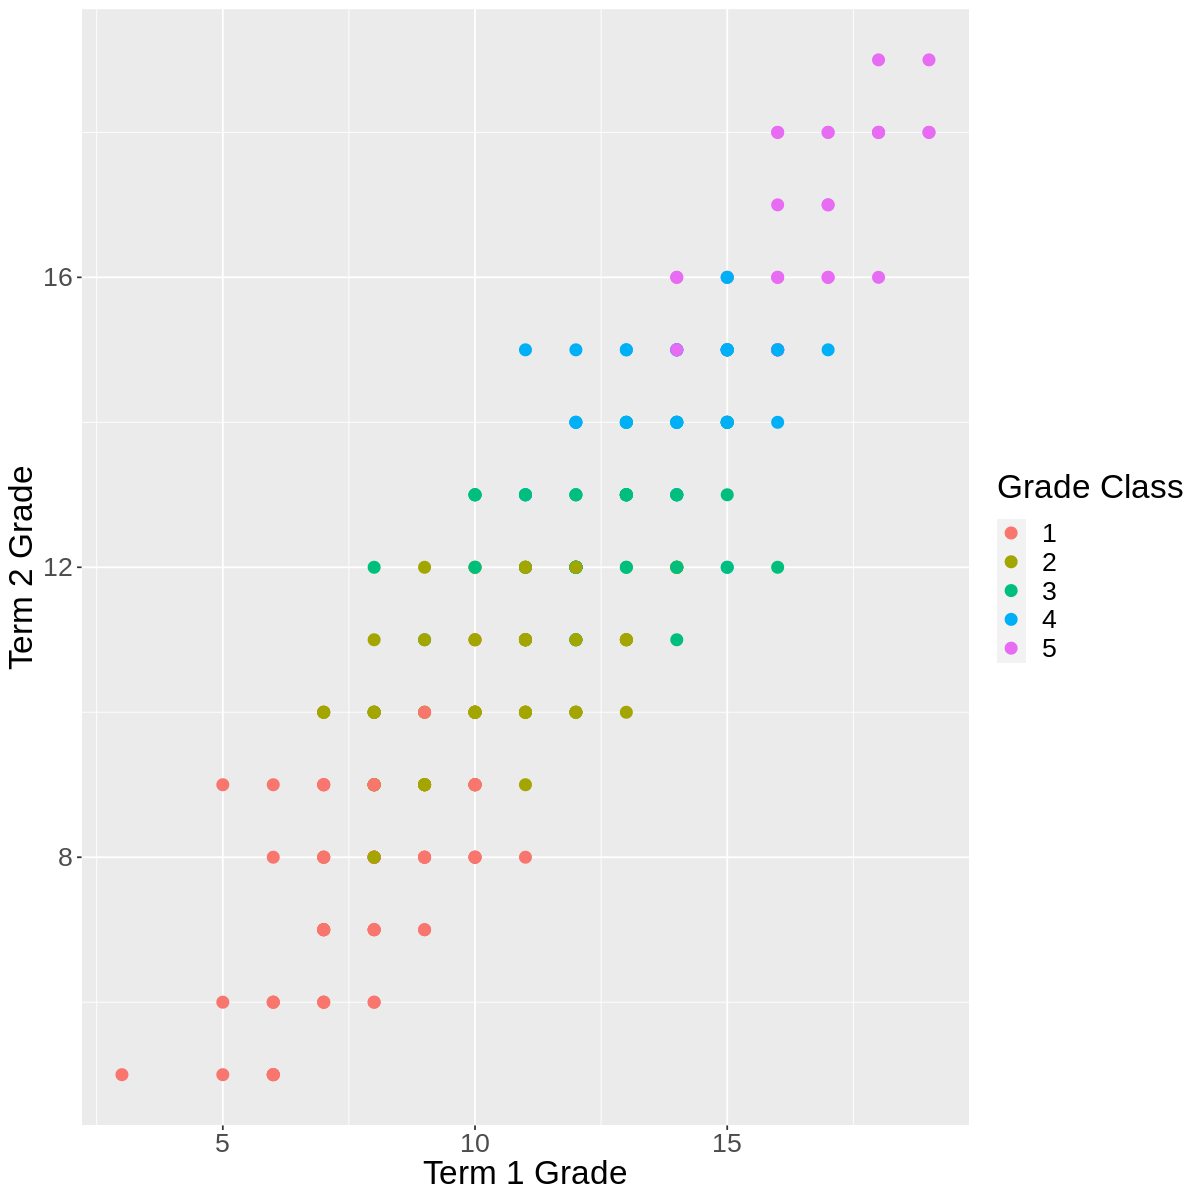

In [46]:
student_plot10 <- ggplot(student_train, aes(x = G1, y = G2, fill = label)) +
    geom_point(aes(color = label), size = 3) +
    labs(x = "Term 1 Grade" , y = "Term 2 Grade", fill = "Grade Class", color = "Grade Class") +
    theme(text = element_text(size = 20))
student_plot10

This graph shows that students generally maintain their grades throughout the year. While this may be a useful indicator to use, it provides little insight into WHY students achieve the grades they do.

**********************Of the remaining factors that were left, we decided to use Mother and Father's education, the student's study time, number of failures, number of absences, and their health as predictors of the student's final grade. This is due to

In [25]:
# model specification to produce a baseline accuracy
set.seed(2021)

# Medu + Fedu + studytime + failures + famrel + health + absences
student_recipe <- recipe(label ~ Medu + Fedu + studytime + failures  + health + absences, 
                         data = student_train) %>%
     step_scale(all_predictors()) %>%
     step_center(all_predictors())
    
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) %>%
     set_engine("kknn") %>%
     set_mode("classification")


knn_fit <- workflow() %>%
     add_recipe(student_recipe) %>%
     add_model(knn_spec) %>%
     fit(data = student_train)

knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~5, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.7137546
Best kernel: rectangular
Best k: 5

In [26]:
#
student_test_pred <- predict(knn_fit, student_test) %>%
    bind_cols(student_test)

accuracy = student_test_pred %>%
    metrics(truth = label, estimate = .pred_class)

confusion = student_test_pred %>%
    conf_mat(truth = label, estimate = .pred_class)

accuracy
confusion

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.25000000
kap,multiclass,0.03119266


          Truth
Prediction 1 2 3 4 5
         1 9 5 4 4 1
         2 6 6 6 5 4
         3 7 9 2 2 2
         4 1 3 1 4 2
         5 0 2 2 0 1

With 5 neighbours we found that the accuracy is only 25% and we can definitely do better. We will tune our classifier in order to increase our accuracy.

In [27]:
# cross-validation

set.seed(2021)

student_vfold <- vfold_cv(student_train, v = 5, strata = label)


student_recipe_2 <- recipe(label ~ Medu + Fedu + studytime + failures  + health + absences, 
                         data = student_train) %>%
     step_scale(all_predictors()) %>%
     step_center(all_predictors())

knn_fit_2 <- workflow() %>%
    add_recipe(student_recipe_2) %>%
    add_model(knn_spec) %>%
    fit_resamples(resamples = student_vfold)

knn_fit_2 %>% collect_metrics()

.metric,.estimator,mean,n,std_err
<chr>,<chr>,<dbl>,<int>,<dbl>
accuracy,multiclass,0.2670518,5,0.01910268
roc_auc,hand_till,0.5201437,5,0.01026682


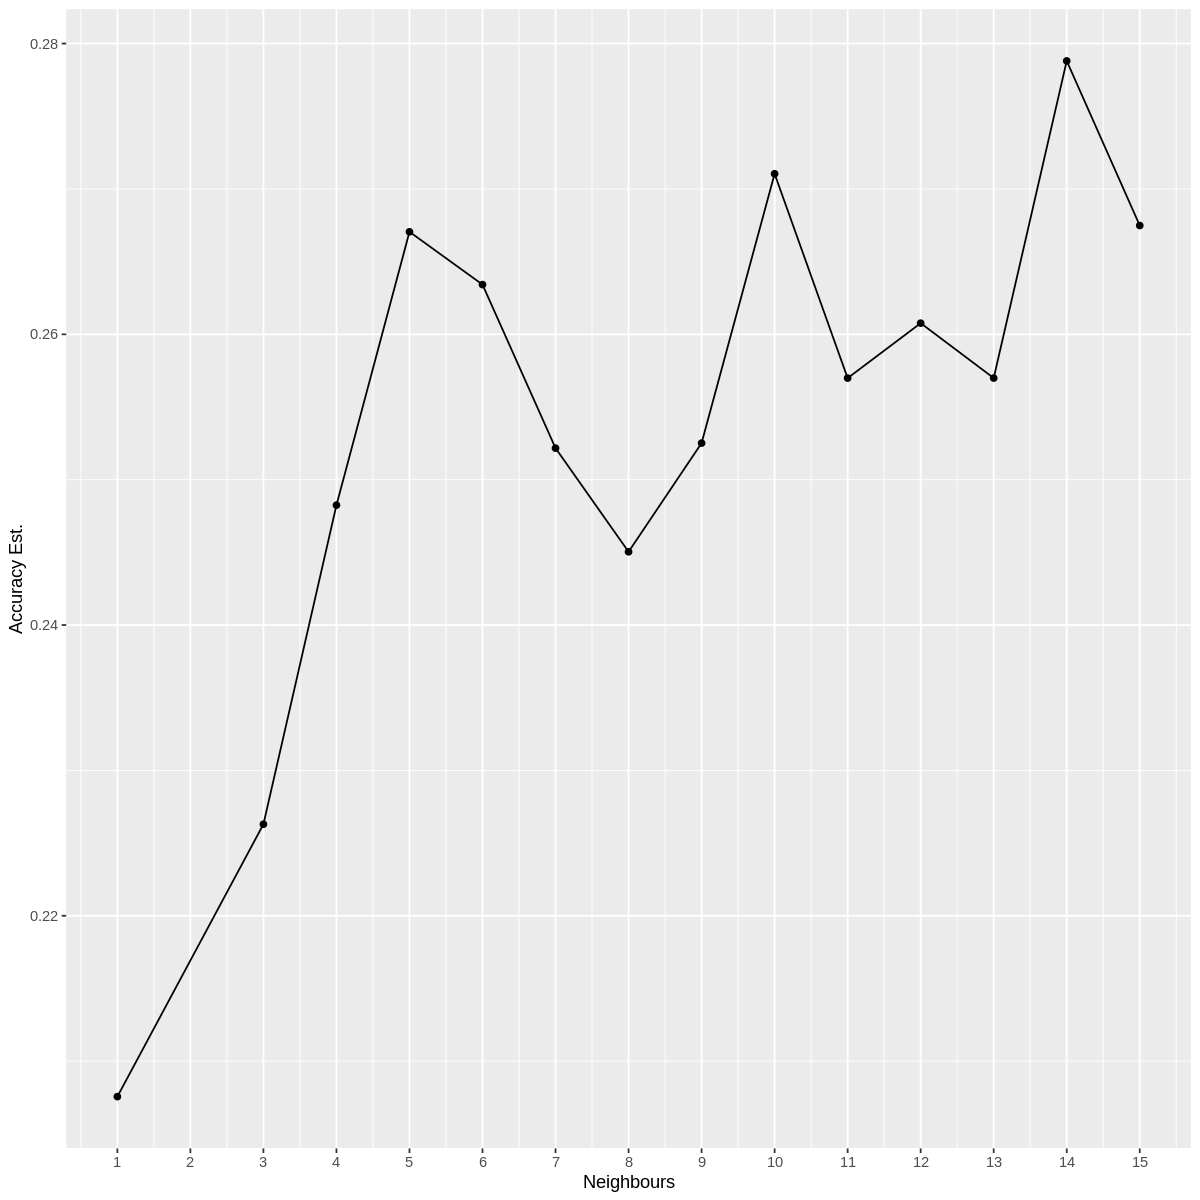

In [29]:
# Finding the best K by plotting accuracy vs K
set.seed(2021)
knn_spec_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")


knn_results_tuned <- workflow() %>%
    add_recipe(student_recipe) %>%
    add_model(knn_spec_tune) %>%
    tune_grid(resamples = student_vfold, grid = 15) %>%
    collect_metrics()


accuracies <- knn_results_tuned %>%
    filter(.metric == "accuracy")

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbours", y = "Accuracy Est.") +
    scale_x_continuous(breaks = 1:15)
    
accuracy_vs_k

The visualization suggests that $K$ =  14 provides the highest accuracy. Unfortunately, the accuracy is only slightly above our previous $K$ of 5. With $K$ = 14, the accuracy increases to just below 28%, while at $K$ = 5, the accuracy was 25%.